In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, Flatten
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom
import cv2
import random
from collections import Counter

### Load Data

In [2]:
x_128_train = np.load('./mhsma/x_128_train.npy')
x_128_valid = np.load('./mhsma/x_128_valid.npy')
x_128_test = np.load('./mhsma/x_128_test.npy')

print(f'Shape of x_128_train : {x_128_train.shape}')
print(f'Shape of x_128_valid : {x_128_valid.shape}')
print(f'Shape of x_128_test : {x_128_test.shape}')

Shape of x_128_train : (1000, 128, 128)
Shape of x_128_valid : (240, 128, 128)
Shape of x_128_test : (300, 128, 128)


In [3]:
y_acrosome_train = np.load('./mhsma/y_acrosome_train.npy')
y_head_train = np.load('./mhsma/y_head_train.npy')
y_tail_train = np.load('./mhsma/y_tail_train.npy')
y_vacuole_train = np.load('./mhsma/y_vacuole_train.npy')

print(f'Shape of y_acrosome_train : {y_acrosome_train.shape}')
print(f'Shape of y_head_train :     {y_head_train.shape}')
print(f'Shape of y_tail_train :     {y_tail_train.shape}')
print(f'Shape of y_vacuole_train :  {y_vacuole_train.shape}')

Shape of y_acrosome_train : (1000,)
Shape of y_head_train :     (1000,)
Shape of y_tail_train :     (1000,)
Shape of y_vacuole_train :  (1000,)


In [4]:
y_acrosome_valid = np.load('./mhsma/y_acrosome_valid.npy')
y_head_valid = np.load('./mhsma/y_head_valid.npy')
y_tail_valid = np.load('./mhsma/y_tail_valid.npy')
y_vacuole_valid = np.load('./mhsma/y_vacuole_valid.npy')

print(f'Shape of y_acrosome_valid : {y_acrosome_valid.shape}')
print(f'Shape of y_head_valid :     {y_head_valid.shape}')
print(f'Shape of y_tail_valid :     {y_tail_valid.shape}')
print(f'Shape of y_vacuole_valid :  {y_vacuole_valid.shape}')

Shape of y_acrosome_valid : (240,)
Shape of y_head_valid :     (240,)
Shape of y_tail_valid :     (240,)
Shape of y_vacuole_valid :  (240,)


In [5]:
print(f'Number of abnormal acrosome : {sum(y_acrosome_train)} of 1000 samples')
print(f'Number of abnormal head : {sum(y_head_train)} of 1000 samples')
print(f'Number of abnormal tail : {sum(y_tail_train)} of 1000 samples')
print(f'Number of abnormal vacuole : {sum(y_vacuole_train)} of 1000 samples')

Number of abnormal acrosome : 301 of 1000 samples
Number of abnormal head : 273 of 1000 samples
Number of abnormal tail : 46 of 1000 samples
Number of abnormal vacuole : 170 of 1000 samples


### Visualization

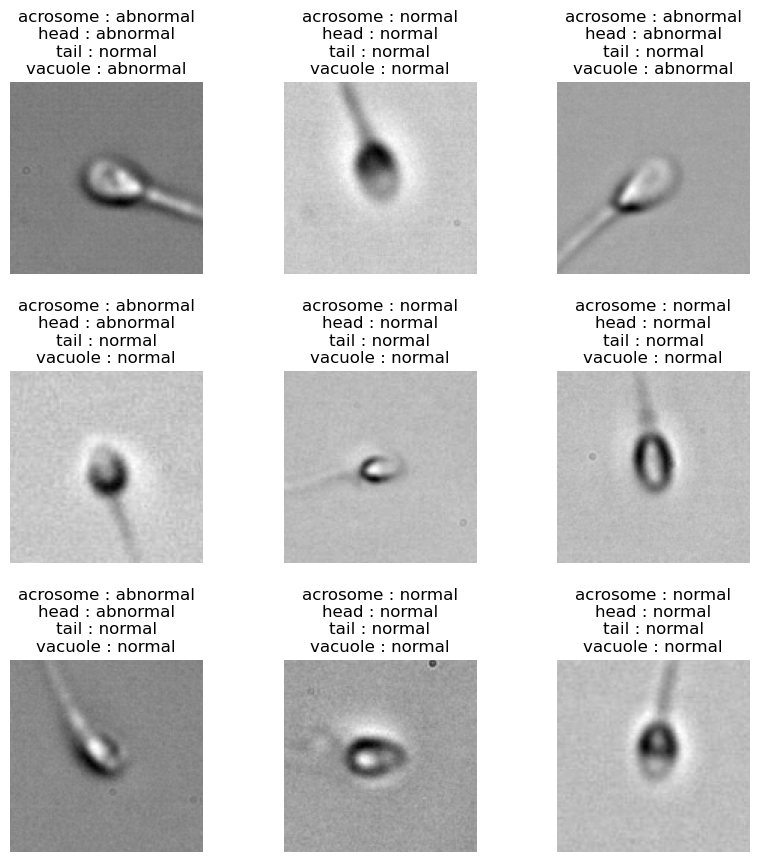

In [6]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(9):
    img = x_128_train[i]
    acrosome = state[y_acrosome_train[i]]
    head = state[y_head_train[i]]
    tail = state[y_tail_train[i]]
    vacuole = state[y_vacuole_train[i]]
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray', )
    plt.title(f'acrosome : {acrosome}\nhead : {head}\ntail : {tail}\nvacuole : {vacuole}')
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')
plt.show()

### Imbalance problem solving with over sampling

##### acrosome

In [7]:
#extract normal and abnormal indexes
normal_index = np.where(y_acrosome_train == 0)[0]
abnormal_index = np.where(y_acrosome_train == 1)[0]

In [8]:
#extend the number of abnormal images by oversampling randomlly
abnormal_index = np.append(abnormal_index, random.choices(abnormal_index, k=len(normal_index)-len(abnormal_index)))
#concatenate normal and abnormal indexes
acrosome_index = np.concatenate([normal_index, abnormal_index])

In [9]:
#shuffle the whole indexes several times
for _ in range(10):
    np.random.shuffle(acrosome_index)

In [10]:
#construct the training dataset and labels for acrosome classification
x_acrosome_train = x_128_train[acrosome_index]
y_acrosome_train = y_acrosome_train[acrosome_index]

In [11]:
print(f'Shape of x_acrosome_train : {x_acrosome_train.shape}')
print(f'Shape of y_acrosome_train : {y_acrosome_train.shape}')

Shape of x_acrosome_train : (1398, 128, 128)
Shape of y_acrosome_train : (1398,)


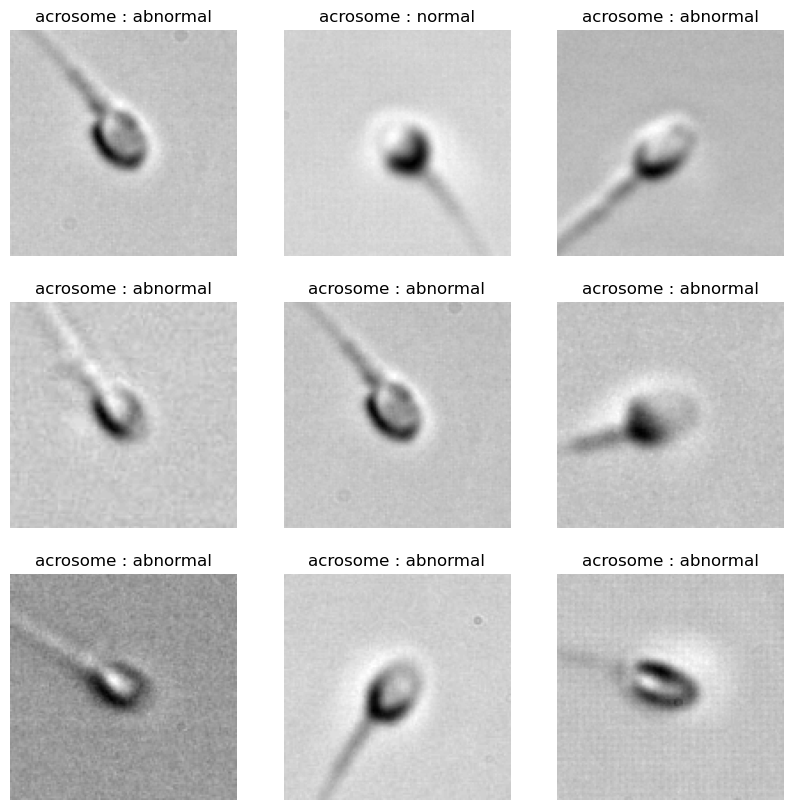

In [12]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(9):
    img = x_acrosome_train[i]
    acrosome = state[y_acrosome_train[i]]
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}')
    plt.axis('off')
plt.show()

### Augmentation

In [13]:
x_acrosome_train_aug = []
for i, img in enumerate(x_acrosome_train):
    if i % 3 == 0 :
        img = cv2.flip(img, 0)
    if i % 4 == 0:
        img = rotate(img, random.randint(20, 90), mode='reflect', reshape=False)
    x_acrosome_train_aug.append(img)
x_acrosome_train_aug = np.array(x_acrosome_train_aug)

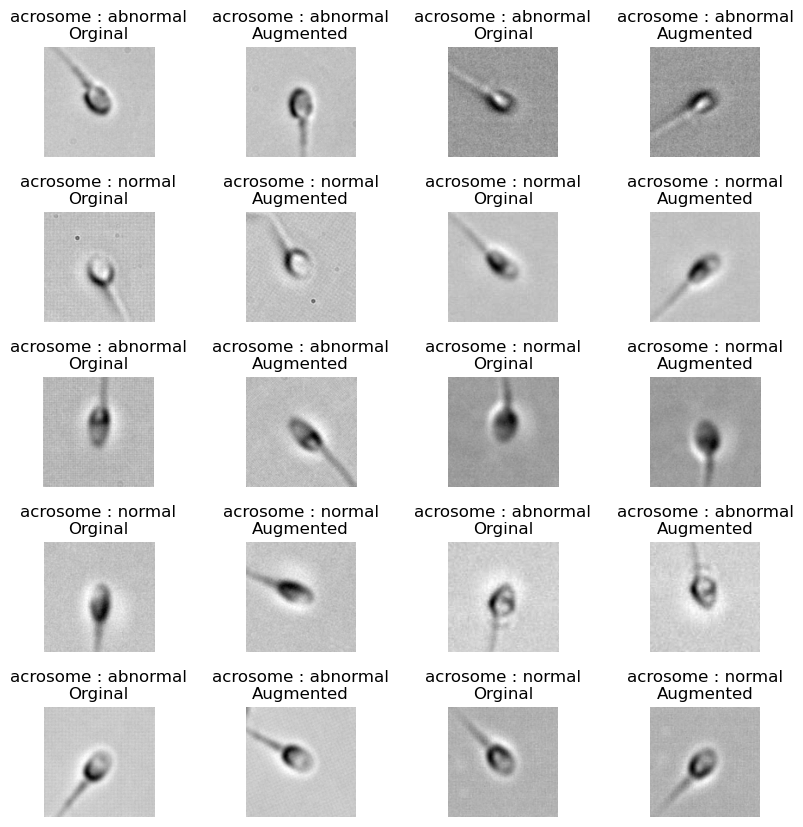

In [14]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(0, 20, 2):
    img = x_acrosome_train[i*3]
    acrosome = state[y_acrosome_train[i*3]]
    ax = plt.subplot(5, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}\nOrginal')
    plt.axis('off')
    
    img = x_acrosome_train_aug[i*3]
    acrosome = state[y_acrosome_train[i*3]]
    ax = plt.subplot(5, 4, i+2)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}\nAugmented')
    plt.axis('off')
    
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

### Normalization

In [15]:
x_train_mean = x_128_train.mean()
x_acrosome_train_aug_mean =  x_acrosome_train_aug.mean()
x_valid_mean = x_128_valid.mean()

In [16]:
x_128_train = (x_128_train - x_train_mean) / 255
x_acrosome_train_aug = (x_acrosome_train_aug - x_acrosome_train_aug_mean) / 255
x_128_valid = (x_128_valid - x_valid_mean) / 255

### Model

In [36]:
model_1 = tf.keras.models.Sequential()

model_1.add(Conv2D(16, (5, 5), padding='same', input_shape=(128, 128, 1), kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(16, (5, 5), padding='same', activation='selu', kernel_initializer=HeNormal()))

model_1.add(MaxPool2D((2, 2), 2))

model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(32, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))

model_1.add(MaxPool2D((2, 2), 2))

model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))

model_1.add(MaxPool2D((2, 2), 2))

model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='selu', kernel_initializer=HeNormal()))

model_1.add(AvgPool2D((2, 2), 2))

model_1.add(Flatten())
model_1.add(Dense(1024, activation='selu', kernel_initializer=HeNormal()))
model_1.add(Dense(256, activation='selu', kernel_initializer=HeNormal()))
model_1.add(Dense(1, activation='sigmoid', kernel_initializer=HeNormal()))

C:\Users\HP ZBOOK 15 G3\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 128, 128, 16)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,145,105 (19.63 MB)

 Trainable params: 5,145,105 (19.63 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [38]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='BinaryCrossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [39]:
model_1.fit(x_acrosome_train_aug, y_acrosome_train, batch_size=64, epochs=8, validation_data=(x_128_valid, y_acrosome_valid))

Epoch 1/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - Precision: 0.5554 - Recall: 0.5185 - accuracy: 0.5278 - loss: 5.3322 - val_Precision: 0.2254 - val_Recall: 0.2424 - val_accuracy: 0.5625 - val_loss: 0.7900
Epoch 2/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - Precision: 0.5909 - Recall: 0.5529 - accuracy: 0.5825 - loss: 0.7772 - val_Precision: 0.3438 - val_Recall: 0.5000 - val_accuracy: 0.6000 - val_loss: 0.7184
Epoch 3/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - Precision: 0.6656 - Recall: 0.6499 - accuracy: 0.6585 - loss: 0.6225 - val_Precision: 0.4348 - val_Recall: 0.1515 - val_accuracy: 0.7125 - val_loss: 0.7158
Epoch 4/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - Precision: 0.7059 - Recall: 0.6238 - accuracy: 0.6900 - loss: 0.6077 - val_Precision: 0.3419 - val_Recall: 0.6061 - val_accuracy: 0.5708 - val_loss: 0.7943
Epoch 5/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - Precision: 0.7949 - Recall: 0.8035 - accuracy: 0.7980 - loss: 0.4395 - val_Precision: 0.3714 - val_Recall: 0.3939 - val_a